Notebook updated on 2025.09.30 and compatible with latest github revisions from that date.

# Imports

In [11]:
import os
import time
import pickle
import copy
import numpy as np
from importlib import reload
from matplotlib import pyplot as plt
from scipy.optimize import leastsq

In [2]:
# https://github.com/asmcleod/common.git
from common import misc
from common.baseclasses import AWA
from common import plotting
from common import numerical_recipes as numrec

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


In [3]:
import ProbeCavityEigenfields as PCE # https://github.com/asmcleod/ProbeCavityEigenfields.git
from ProbeCavityEigenfields import RotationalMoM as RotMOM
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from ProbeCavityEigenfields import EigenInversion as EI 

# Load probe and encoding from file

In [4]:
# Pickle files associated with probe "hyperboloid" should be distributed with this notebook, but other probes can be used

#--- Load a probe that will serve as predictor
#probe_name = 'Hyperboloid=20nm_L=23microns_Nnodes=488' # This model is very fine-tuned, and has cgs units (probe radius = 20e-7 cm) 
probe_name = 'hyperboloid'
ProbeEncoded = PCE.load(probe_name,PS.EncodedEigenfields)
Probe = ProbeEncoded.get_probe()

<__init__._ProbesCollection.__setitem__>:
	Registering probe "hyperboloid"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_EncodedEigenfields.pickle"!


In [5]:
#The stored `Encoding` object should already have this library computed.
#Enc.build_Rmat2D_library(qps=np.logspace(-3, 2, 50))

# Define fast Predictor for 2D material on substrate

This tool is optimized to quickly simulate near-field signal at light frequency $\omega$ from a 2D material of conductivity $\sigma_{2D}(\omega)$ sitting atop a substrate material with permittivity $\epsilon_\mathrm{subs}(\omega)$.  In practice, throughout this business the optical conductivity $\sigma_{2D}$ is re-parametrized into a more convenient measure called the "plasmon wavevector" $q_p$ which is defined as:

$q_p(\omega)=i\omega/(2\pi\sigma_{2D}(\omega))$

This is not the only relation betwen $q_p$ and optical properties of a thin material.  If we consider $\sigma_{2D}=\sigma_{3D} \cdot t$ as the 2D (sheet) conductivity associated with a thin material of bulk conductivity $\sigma_{3D}$ (we may drop the subscript "3D") and thickness $t$, then we can use the relation $\epsilon(\omega)=1+4\pi i \sigma(\omega)/\omega$ to relate $q_p$ to $\epsilon$, the (bulk) permittivity of the thin material:

$\sigma_{2D} = \frac{i\omega}{4\pi} (1-\epsilon), \quad$    thus:    $\quad q_p(\omega)\,t =2/(1-\epsilon)$.

In terms of this wavevector value, the near-field reflectivity of the 2D material atop the substrate is given as function of illumination wave-vector $q$ by:

$R(q,\omega) = (\beta \cdot q_{p,scr} - q)/(q_{p,scr}-q)$.

Here $\beta(\omega)\equiv (\epsilon_\mathrm{subs}(\omega)-1)/(\epsilon_\mathrm{subs}(\omega)+1)$ describes the reflectivity of the substrate even if no 2D material were present (in which case $q_p\rightarrow\infty$), and $q_{p,scr}$ is the screened plasmon wavevector given by $q_{p,scr}(\omega)=q_p(\omega) \cdot (\epsilon_\mathrm{subs}(\omega)+1)/2$.

In truth, with an optical probe of typical tip radius $a$, the strength of optical interaction between the probe and the 2D material will be controlled by the dimensionless product $q_p \cdot a$.  This can be seen by the fact that such a probe may illuminate the 2D material with light fields of characteristic momentum $q^*\sim 1/a$.

Thus, calculations are all performed by providing the dimensionless value of $\bar{q}_p \equiv q_p\cdot a$ in lieu of the dimensionful plasmon wavevector, and also any extraction of $q_p$ with this tool will also measure the plasmon wavevector in units of $q^*$.  Namely, extraction can return the following value:

$\bar{q}_p \equiv q_p/q^* = q_p\cdot a =q_p\,t \cdot a/t =2/(1-\epsilon)\cdot a/t$.

Reversing the relation, note that $\epsilon$ might be obtained from $\bar{q}_p$ as:

$\epsilon = 1-2 a/(\bar{q}_p\,t) $

In [6]:
#--- Set up our predictor for near-field signal
# We will take reference signal for material with high permittivity (gold)
# zmin = minimum approach distance (rel. tip radius) of probe to sample (don't make it too small, we'll have an error)
# A = amplitude of tapping (rel. tip radius)
# Nts = number of time points in the tapping to include in the simulation
# harmonic = e.g. 3 for simulating 3rd harmonic data
# qp_ref = the qp value (rel. tip radius) of the 2D material in the normalization material (make ~infinity to deactivate 2D material)
# eps_ref = the permittivity of the substrate in the normalization material (make ~infinity to resemble a good metal like gold)
a = Probe.get_a() # tip radius
reload(EI)
Predictor = EI.EncodedEigenfieldsPredictor(ProbeEncoded,
                                           zmin=a/10, A=4*a, Nts=24,
                                            harmonic=3,
                                            qp_ref=1e8/a,
                                            eps_ref=1e8,
                                           Nmodes=15) # More eigenmodes, more accuracy, more expense!

# Practice computing some spectra for different $q_p$

In [7]:
# Using the library, we can rapidly compute near-field contrast of 2D material on any substrate.
# Choose silicon oxide permittivity as our substrate.
from NearFieldOptics import Materials as M
freqs = np.linspace(600,1500,100)
epss = M.SiO2_300nm.epsilon(freqs)

# Decide at what tip-sample gaps we will compute scattered field.  This scattered field E vs. gap = "approach curve."
zmin=.1; A=5 # minimum approach height, and tapping amplitude (= 5 x tip radius ~ 100 nm)
at_gaps = np.linspace(zmin,zmin+2*A,100)

# Choose many hypothetical values of plasma momentum `qp` of 2D layer.  Compute scattered field at all gaps.
Sns={}
for qp in np.logspace(-3,1,5):

    #For this value of `qp`, compute a series of optical contrasts
    Sns_at_qp = []
    for i,eps in enumerate(epss):
        p = i/len(epss)*100
        print('qp = %s, Progress=%i%%'%(qp,p),end='\r',flush=True)
        Sn = Predictor(qp,eps)
        Sns_at_qp.append(Sn)
    print('\n')

    Sns_at_qp = AWA(Sns_at_qp,axes=[freqs],axis_names=['$\omega$ (cm$^{-1}$)'])
    Sns[qp] = Sns_at_qp


<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.Ta

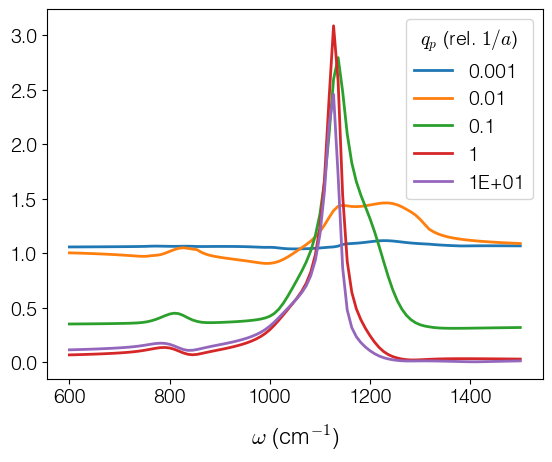

In [8]:
# Plot the spectrum for each choice of `qp`.
# Decreasing `qp` means the 2D material gets more metallic.
harmonic = 2
qps = sorted(list(Sns.keys()))
for qp in qps:
    np.abs(Sns[qp]).plot(label='%1.1G'%qp)
plt.legend(title='$q_p$ (rel. $1/a$)')

# Inversion of $q_p$

## Define a simple residual

In [23]:
def residual(args,
             *extra_args):

    qp_real,qp_imag = args
    S_target_real,S_target_imag,Predictor,eps,exp = extra_args

    S_target = S_target_real + 1j*S_target_imag
    qp = qp_real + 1j*qp_imag
    prediction = Predictor(qp,eps)

    to_minimize = [np.abs(np.real(prediction - S_target))**exp,
                   np.abs(np.imag(prediction - S_target))**exp]
    

    return to_minimize

## Practice inversion of qp at one known value of substrate permittivity

In [24]:
# Parameters for probe model
harmonic = 2
zmin = 0.1 # distance of closest approach of probe to sample ( units of tip radius)
A=4 # tapping amplitude (units of tip radius)

# Something we knew about our measurement - the substrate permittivity
eps = 6
# The ground truth
qp_actual = .5+.1j

# The simulated signal
S_target = Predictor(qp_actual,eps) # suppose this were our measurement

# Least squares solution for inversion
t0 = time.time()
exp=1
qp_0 = (1,.1) # starting guess for `qp`
result = leastsq(residual,qp_0, args=(S_target.real,S_target.imag,
                                    Predictor,eps,exp),
                 factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]

print('Elapsed:',time.time()-t0)
qp_predicted = result[0]+1j*result[1]

print('qp Actual:',qp_actual)
print('qp Predicted:',qp_predicted)

print('S actual:',Predictor(qp_actual,eps))
print('S predicted:',Predictor(qp_predicted,eps))



Elapsed: 0.21865320205688477
qp Actual: (0.5+0.1j)
qp Predicted: (0.49999999964300135+0.1000000003130591j)
S actual: (0.24755012537922189+0.0015147437237459486j)
S predicted: (0.24755012541508054+0.0015147438002520548j)


## Inversion at a series of known permittivities $\varepsilon(\omega)$, to obtain spectrum $q_p(\omega)$

We will pretend we have acquired some near-field data from a "unknown" 2D material upon a "known" substrate - this means, $q_p(\omega)$ is not known, but we suppose that $\epsilon(\omega)$ is known because we have pre-characterized the substrate.  This means to say, suppose we have acquired a gold-normalized spectrum from our substrate, and that our model (`Predictor`, with `Sref` set to `S_Au`) successfully reproduces the substrate spectrum.

Now we are ready to supply our gold-normalized spectrum from the 2D material.  By supplying known values of $\epsilon(\omega)$, we can fit our near-field signal at each frequency to the $q_p(\omega)$ of best match.

Text(0, 0.5, '$S_2$ (rel. Au)')

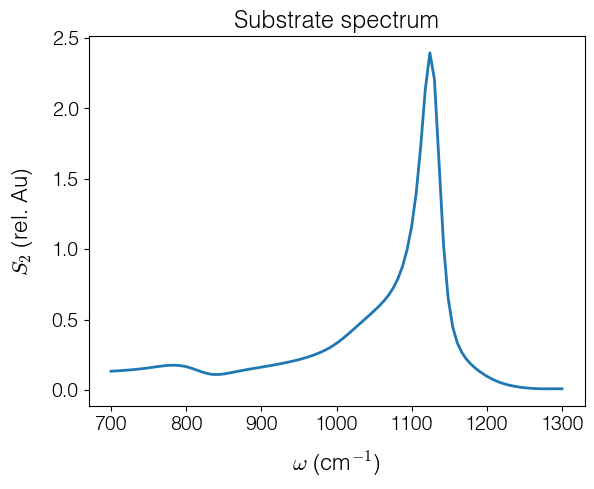

In [27]:
#--- Decide the underlying substrate material we will simulate
# Here we will choose SiO2, which is assumed to be thick enough to resemble bulk SiO2
freqs = np.linspace(700,1300,100)
epss = M.SiO2_300nm.epsilon(freqs) # Our `known` permittivities of substrate at our energies of measurement

S0 = [Predictor(qp=1e3,eps=eps) \
      for eps in epss] # Predict spectrum of underlying substrate
S0 = AWA(S0,axes=[freqs],axis_names=[r'$\omega$ (cm$^{-1}$)'])

np.abs(S0).plot()
plt.title('Substrate spectrum')
plt.ylabel(r'$S_2$ (rel. Au)')


In [28]:
#--- Build ground truth qp values, and simulate the measurement
# Either we will do fitting to $q_p$ from a simulated target
# (a synthesized example of data we might measure with noise on top)
# OR we will be fitting to actual gold-normalized data

simulate_target = True
if simulate_target:
    Q=5 # plasmonic quality factor
    qps_actual = np.linspace(.05,0.1,len(freqs))*(1+1j/Q)
    S_targets = [Predictor(qp_actual,eps) 
                 for qp_actual,eps in zip(qps_actual,epss)]
    S_targets = np.array(S_targets) # Model will try to reproduce this 'target'
    
    #--- Add noise to the simulated values (obviously remove this for actual data)
    n=0.05
    S_targets += n*np.random.randn(len(freqs))
    
else:
    # Here put our measurement: numeric complex values of the measured normalized signal
    pass

#--- Try to predict a signal matching target at each frequency

exp=1 # This is a parameter of the residual function for fitting
qps_pred = [] # We will fill this with predicted `q_p` values at each frequency
qp_pred = 0.1+.1j # This is an initial guess to get the nonlinear fitting started

for freq,eps,S_target in zip(freqs,epss,S_targets):
    t0 = time.time()
    x0 = (qp_pred.real,qp_pred.imag)
    result = leastsq(residual,x0, args=(S_target.real,S_target.imag,
                                        Predictor,eps,exp),
                     factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]
    print('freq=%1.2f'%freq,'; Elapsed: %1.3f'%(time.time()-t0),
          end='\r',flush=True)
    qp_pred = result[0]+1j*result[1]
    qps_pred.append(qp_pred)


#--- See what spectrum is implied by the predicted qp values

# coerce to what predictor "sees" during optimization
qps_pred = Predictor.massage_arg(np.array(qps_pred))
S_preds = [Predictor(qp_pred,eps) for qp_pred,eps in zip(qps_pred,epss)]

<>:5: DeprecationWarning: invalid escape sequence \i
<>:5: DeprecationWarning: invalid escape sequence \i
/var/folders/67/32mwwcnj2pl1mtqhfc7mzlz80000gn/T/ipykernel_16653/1687244409.py:5: DeprecationWarning: invalid escape sequence \i
  plt.plot(freqs,np.abs(S0),label='substrate ($q_p = \infty$)')


Text(0, 0.5, '$q_p \\cdot a$')

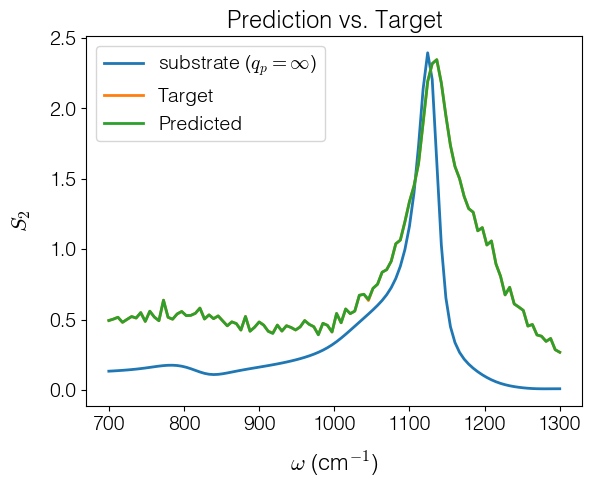

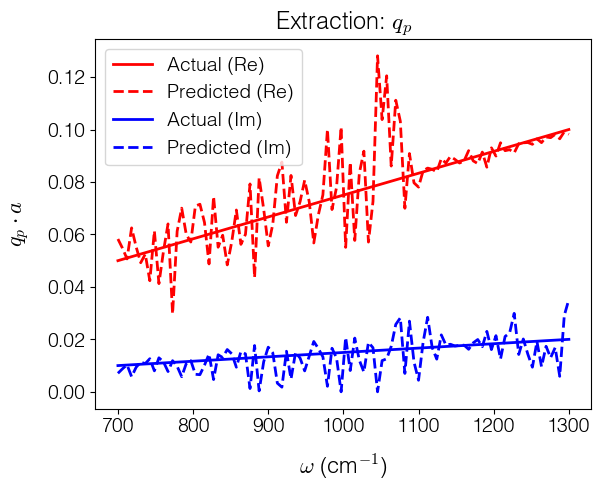

In [29]:
# Let's see how well the "best fit" matches the target!

#--- Plot signals
plt.figure()
plt.plot(freqs,np.abs(S0),label='substrate ($q_p = \infty$)')
plt.plot(freqs,np.abs(S_targets),label='Target')
plt.plot(freqs,np.abs(S_preds),label='Predicted')
plt.legend()
plt.title('Prediction vs. Target')
plt.xlabel(r'$\omega$ (cm$^{-1}$)')
plt.ylabel(r'$S_%i$'%harmonic)

# Let's also see how the extracted $q_p$ depends on frequency,
# and how well it matches the `ground truth` values (which had no noise)

#--- Plot predicted qp vs. ground truth
plt.figure()
plt.plot(freqs,qps_actual.real,label='Actual (Re)',color='r')
plt.plot(freqs,qps_pred.real,label='Predicted (Re)',color='r',ls='--')
plt.plot(freqs,qps_actual.imag,label='Actual (Im)',color='b')
plt.plot(freqs,qps_pred.imag,label='Predicted (Im)',color='b',ls='--')
plt.legend()
plt.title(r'Extraction: $q_p$')
plt.xlabel(r'$\omega$ (cm$^{-1}$)')
plt.ylabel(r'$q_p \cdot a$')